In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853

### Plotting code

In [74]:
def plotTimeSeries(t, y, min_freq=None, max_freq=None, nq=None, spp=10, true_freq=None, LS_xlim=None, plot_harmonics=False, title=None):
    frequency, power = LombScargle(t,y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, nyquist_factor=nq, samples_per_peak=spp)
    
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    ax00 = fig.add_subplot(gs[0, :])
    ax00.plot(t, y)
    ax00.set_xlabel('time')
    ax00.set_ylabel('signal')
    if title is not None:
        ax00.set_title('{0} time series'.format(title))
    else:
        ax00.set_title('time series')

    ax10 = fig.add_subplot(gs[1, 0])
    ax10.hist(y,bins=30)
    ax10.set_xlabel('signal')
    ax10.set_ylabel('count')
    ax10.set_title('Histogram')


    ax11 = fig.add_subplot(gs[1, 1])
    ax11.plot(frequency, power)
    ax11.set_xlabel('frequency [cycles/time unit]')
    ax11.set_ylabel('power [dimensionless]')
    ax11.set_title('Lomb-Scargle periodogram')
    if LS_xlim is not None:
        ax11.set_xlim(LS_xlim)
    if true_freq is not None:
        [ax11.axvline(x, color='r',lw=0.5) for x in true_freq]
        if plot_harmonics is True:
            [ax11.axvline(x, color='b',lw=0.5) for x in true_freq/2.]
            [ax11.axvline(x, color='g',lw=0.5) for x in true_freq/3.]
        
    plt.show()
    return 

### Gaussian noise, multi-periodic signal, and Rossler signal

In [75]:
# multi-periodic signal from Kovacs & Buchler 1988
def KB88(t,a1=1.0,a2=0.6,a3=0.2,v1=0.1,v2=0.048,v3=0.0252):
    w1 = 2*np.pi*v1
    w2 = 2*np.pi*v2
    w3 = 2*np.pi*v3
    
    # length t + 1
    t2 = np.append(t, t[-1] + np.mean(t[1:] - t[0:-1]))
    
    r = a1 * np.cos(w1 * t2) + a2 * np.cos(w2 * t2) + a3 * np.cos(w3 * t2) \
        + 0.5 * a1 * a3 * (np.cos( (w1 + w3) * t2) + np.cos( (w1 - w3) * t2)) \
        + 0.1 * a2 * a3 * (np.cos( (w2 + w3) * t2) + np.cos( (w2 - w3) * t2)) \
        + 0.1 * a1 * a2 * (np.cos( (w1 + w2) * t2) + np.cos( (w1 - w2) * t2)) \
        + 0.1 * a1**2 * np.cos(2. * w1 * t2) \
        + 0.1 * a2**2 * np.cos(2. * w2 * t2)
    
    v = (r[1:] - r[0:-1])/np.mean(t[1:] - t[0:-1])
        
    return r[:-1], v

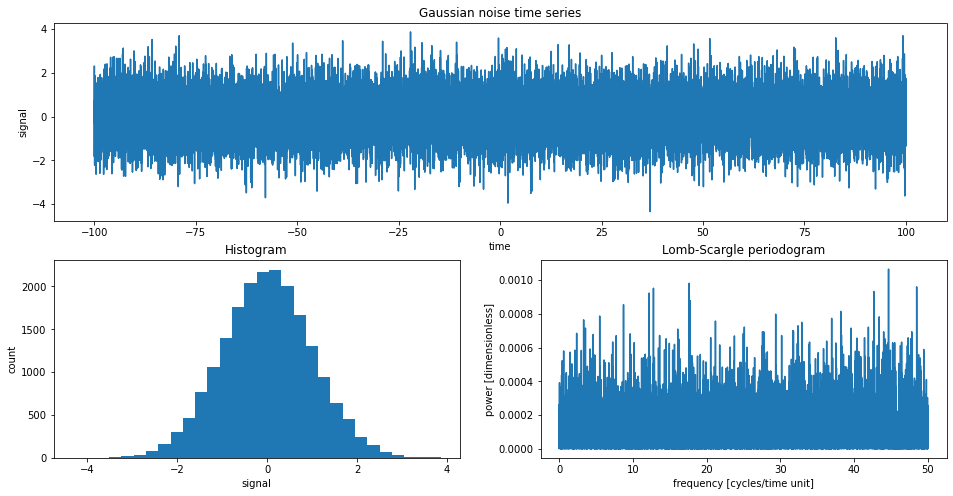

In [79]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

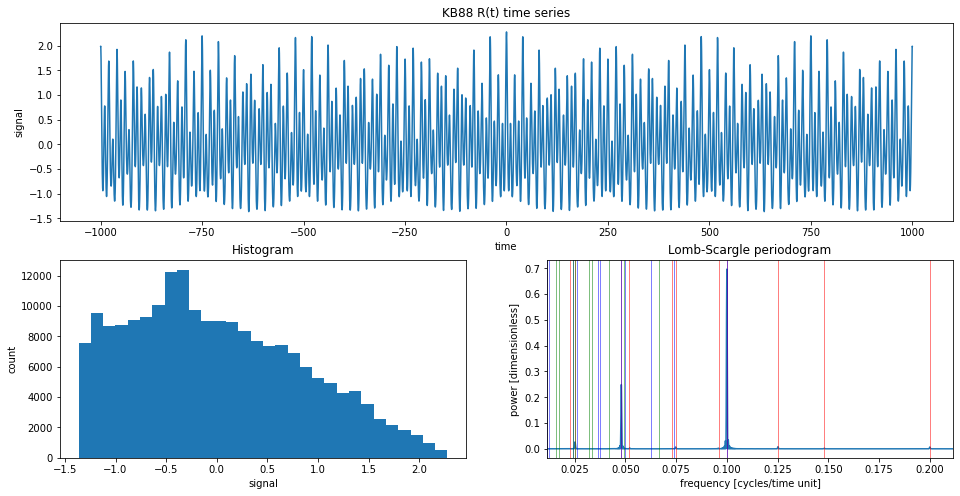

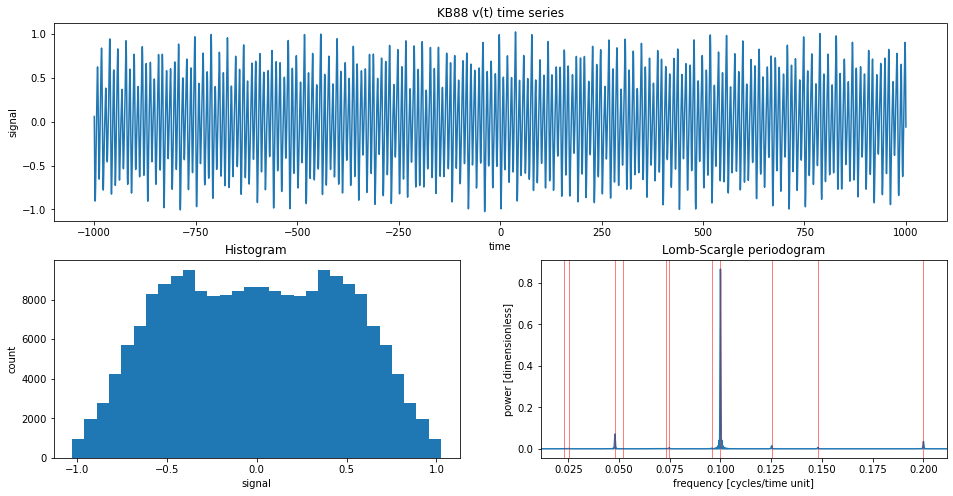

In [77]:
dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")

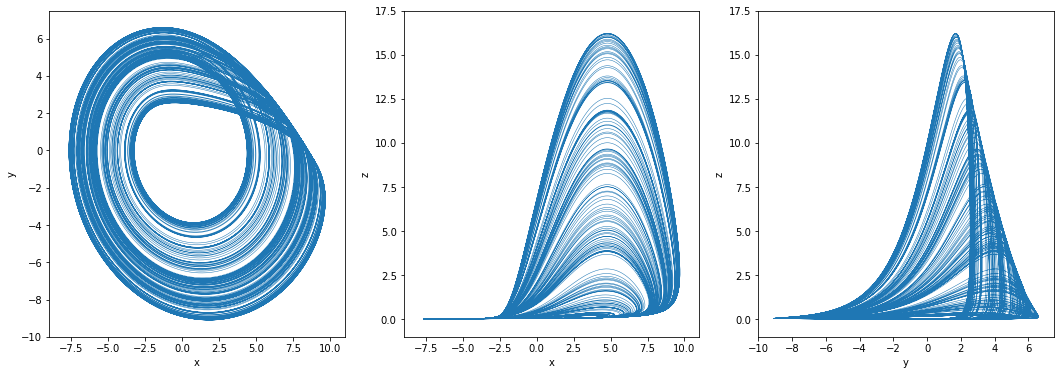

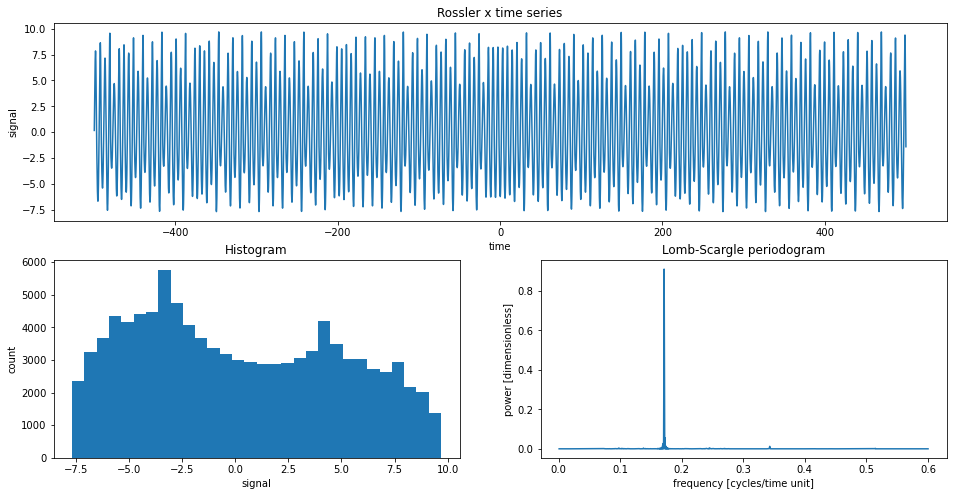

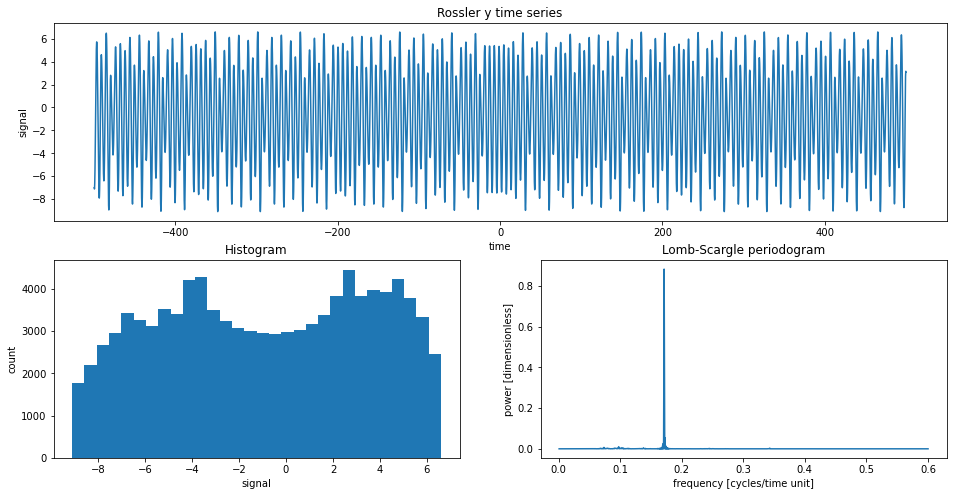

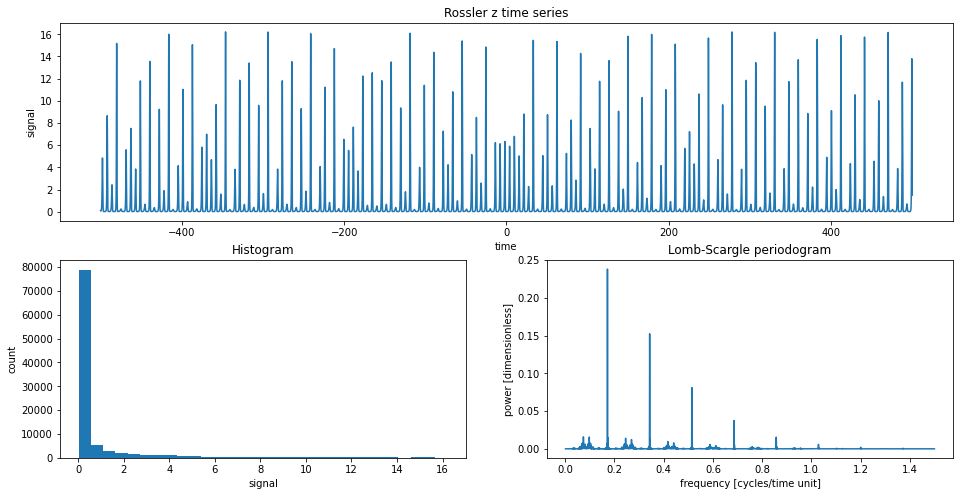

In [109]:
def Rossler_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    a=0.2
    b=0.2
    c=4.8
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    v_x = -y - z
    v_y = x + a*y
    v_z = b + z*(x - c)
    
    return np.array((v_x, v_y, v_z))

r0 = np.array((0.1, -7, 0.1))
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((Nsteps,3))
rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-9,11)
axes[0].set_ylim(-10,7.5)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-9,11)
axes[1].set_ylim(-1,17.5)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-10,7.5)
axes[2].set_ylim(-1,17.5)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

#plotTimeSeries(rossler_t,rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,0.6),title="Rossler x")
#plotTimeSeries(rossler_t,rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.),title="Rossler y")
#plotTimeSeries(rossler_t,rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.5),title="Rossler z")

plotTimeSeries(rossler_t, rossler_r[:,0], min_freq=(1./baseline), max_freq=0.6, spp=500, title="Rossler x")
plotTimeSeries(rossler_t, rossler_r[:,1], min_freq=(1./baseline), max_freq=0.6, spp=500, title="Rossler y")
plotTimeSeries(rossler_t, rossler_r[:,2], min_freq=(1./baseline), max_freq=1.5, spp=500, title="Rossler z")